# 11_04: Estimating sampling errors with Monte Carlo

In [1]:
import math
import collections
import dataclasses
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as pp

In this chapter we have seen how modeling can help us understand data by giving us estimates of the model parameters. These estimates are necessarily imperfect because models are never be faithful representations of reality. Nevertheless, models can be very useful!

But we can also ask a different type of question---a question about a real property of a underlying population. For instance, the number of voters in a district that support a certain politician. This number really exists, and we could compute it if we could ask any single voter (and if they replied, of course). But in practice we will have access only to a limited _sample_ --- say, 1000 randomly chosen voters --- so our estimate is going to be uncertain. But how uncertain?

Statistics offers sophisticated mathematical methods to tackle this kind of questions. Since however this is not a course about statistics, what I want to show you is that we can get answers with little mathematics by resorting to simulations based on random numbers. Physicists call this Monte Carlo, because it's very much like gambling.

So imagine a very important election is taking place in your city, pitting incumbent mayor, Mr. Brown, against a local celebrity chef, Mrs. Green. You work for the local newspaper, and you are asked to poll your co-citizens for their vote. To make things easy for you, we'll assume you can reach every voter by phone, and that every polled voter replies truthfully. Laboriously, you call 1000 voters and ask for their voting intention. Here's a file of their answers.

In [4]:
poll = pd.read_csv('poll.csv')
poll.head()

,vote
0,Brown
1,Green
2,Brown
3,Brown
4,Brown


Here are the measured proportions of votes for the two candidates.

In [6]:
poll.value_counts(normalize=True)

vote 
Brown    0.511
Green    0.489
Name: proportion, dtype: float64

It seems Brown will remain Mayor. However the proportion is going to depend on the specific sample that we drew. How much?

Let's simulate a thousand-voter sample when the true proportion is 51 to 49 percent. NumPy has a very handy function for this.

In [71]:
def makepoll(nsample=1000, brown=0.51):
    return pd.DataFrame({'vote': np.random.choice(['Brown', 'Green'], nsample, p=[brown, 1.0 - brown])})

In [72]:
makepoll().value_counts(normalize=True)

vote 
Brown    0.507
Green    0.493
Name: proportion, dtype: float64

So it's a little different, as we expected. Now let's repeat the simulation many times, and collect Brown's share.

In [98]:
def makedist(ntries=2000, nsample=1000, brown=0.51):
    return pd.DataFrame([makepoll(nsample, brown).value_counts(normalize=True) for i in range(ntries)])

In [99]:
counts = makedist()

Plotting a histogram of this **sampling distribution**, we see that a true share of 0.51 may result in fractions between (roughly) 0.48 and 0.54 in a sample of 1000. This means also that if we observe a majority of 51% for Brown in the sample, the winner may very well be Green.

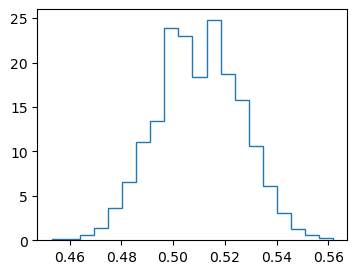

In [100]:
pp.figure(figsize=(4,3))
pp.hist(counts['Brown'], histtype='step', bins=20, density=True);

Computing summary statistics shows that the error is about 1.5%, and the interquartile range is 50% to 52%.

Indeed, that means that with a true Brown majority of 51%, the poll would yield Green as winner about 25% of the times. Journalists must be careful!

In [101]:
counts.Brown.describe()

vote,Brown
count,2000.000000
mean,0.509907
std,0.016124
min,0.453000
25%,0.499000
50%,0.510000
75%,0.521000
max,0.562000


The fun thing with simulations is that it's easy to verify our intuition. For instance, a slightly stronger true majority for Brown would almost never result in an uncertain poll:

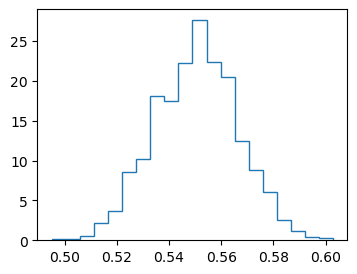

In [102]:
pp.figure(figsize=(4,3))
pp.hist(makedist(2000, 1000, 0.55)['Brown'], histtype='step', bins=20, density=True);

And a larger poll of 10000 would be more precise than a poll of 1000.

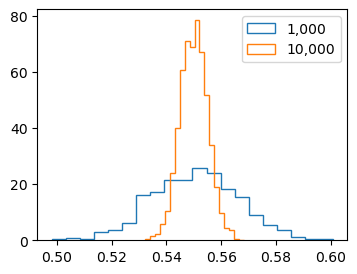

In [104]:
pp.figure(figsize=(4,3))
pp.hist(makedist(2000, 1000, 0.55)['Brown'], histtype='step', bins=20, density=True, label='1,000')
pp.hist(makedist(2000, 10000, 0.55)['Brown'], histtype='step', bins=20, density=True, label='10,000')
pp.legend();

Statisticians make precise statements about the uncertainty of polling by giving **confidence intervals**. They will say: given this sampling, 95% of the times the true value would fall within this range. How do we find that?

A 95% confidence interval means that we can be wrong 5% of the time. We'll split that equally between being too high and too low.

So we look for the true vote fraction for which the lowest 2.5% of the sampling distribution lies below 0.51. That's about 54%.

In [105]:
makedist(2000, 1000, 0.55)['Brown'].quantile(0.025)

vote 
Brown    0.52
Name: 0.025, dtype: float64

In [112]:
makedist(2000, 1000, 0.54)['Brown'].quantile(0.025)

vote 
Brown    0.508975
Name: 0.025, dtype: float64

And we look for the true vote fraction for which the highest 2.5% of the sampling distribution lies above 0.51. That's about 48%.

In [119]:
makedist(2000, 1000, 0.47)['Brown'].quantile(0.975)

vote 
Brown    0.501025
Name: 0.975, dtype: float64

In [120]:
makedist(2000, 1000, 0.48)['Brown'].quantile(0.975)

vote 
Brown    0.511
Name: 0.975, dtype: float64

So the 95% confidence interval for a finding of 51% in a 1,000-voter poll is between 48% and 54%.

This is a simple analysis, but it gives you a good sense of how professional pollsters actually estimate their errors. Except they have to deal with the complications of reality, such as the fact that any polling may overrepresent some segments of the population and underrepresent others (this would be a **selection bias**), as well as the fact that voters may not respond truthfully (this would be a **response bias**).